![](https://www.ieseg.fr/wp-content/uploads/IESEG-Logo-2012-rgb.jpg)

# Hybrid Recommendation Systems

In [1]:
import pandas as pd 
import numpy as np 
from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD
import matplotlib.pyplot as plt

# NLP packages
import nltk # pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimitrikestenbaum/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimitrikestenbaum/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Load data
text = pd.read_csv('Data-20220301/jester/JokeText.csv')
data = pd.read_csv('Data-20220301/jester/jester_train.csv').sample(frac=0.1, random_state=42).reset_index(drop=True)

In [8]:
data.head()

,user,item,rating
0,10703,83,1.80
1,56311,79,-7.38
2,38277,47,1.84
3,5609,90,3.06
4,10655,33,-7.18


In [10]:
# train-test split
train, test = train_test_split(data, test_size=0.3, random_state=42)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(data.shape)
print(train.shape)
print(test.shape)

(161595, 3)
(113116, 3)
(48479, 3)


# Preprocessing text data

In [11]:
# Tokenize, case conversion & only alphabetic
tokens = text['JokeText'].apply(lambda txt: [word.lower() for word in word_tokenize(str(txt)) if word.isalpha()])
# setup stop words list
stop_words = stopwords.words('english')
stop_words.append('nan')

stemmer = SnowballStemmer("english")

# remove stopwords, stem
token_stem = tokens.apply(lambda lst_token: [stemmer.stem(tok) for tok in lst_token if tok not in stop_words and len(tok) > 2])

In [12]:
# TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5)

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in token_stem])

print(dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names(), index=text.index)
df_dtm.head()

(100, 71)


,anoth,answer,ask,back,bar,bill,call,car,chang,clinton,...,use,walk,want,well,wife,woman,work,would,year,yes
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.467335,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.238011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.295167,0.0,0.303372,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.650491,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


# Recommendations

In [6]:
reader = Reader(rating_scale=(-10, 10))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

In [7]:
# content-based
cb = ContentBased(NN=10)
cb.fit(df_dtm)
cb.fit_ratings(df_train)
cb_pred = cb.test(df_test)

# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)
ib.fit(df_train)
ib_pred = ib.test(df_test)

# svd
mf = SVD(n_factors=20, biased=False, random_state=42)
mf.fit(df_train)
mf_pred = mf.test(df_test)

models = {"CB_10":cb_pred, "IB_15":ib_pred, "SVD_20":mf_pred}
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=5) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

c:\Users\p.borchert\OneDrive - KU Leuven\Courses\Teaching\Recommendation Systems\2022\Examples Python\IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


Computing the cosine similarity matrix...
Done computing similarity matrix.


,CB_10,IB_15,SVD_20
RMSE,5.649795,5.290807,5.380787
MAE,4.384503,4.409676,4.445502
Recall,0.252281,0.022157,0.035435
Precision,0.486338,0.631090,0.504640
F1,0.332225,0.042811,0.066220
NDCG@5,0.930289,0.930603,0.931392


In [8]:
models = {"CB_10":cb_pred, "IB_15":ib_pred, "SVD_20":mf_pred}
overview = pd.concat([eval.evaluate(mod, topn=10, rating_cutoff=5, excl_impossible=True) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

Excluded 9608 (48479) samples. 38871 remaining ...
Excluded 9608 (48479) samples. 38871 remaining ...
Excluded 44886 (48479) samples. 3593 remaining ...
Excluded 44886 (48479) samples. 3593 remaining ...
Excluded 7667 (48479) samples. 40812 remaining ...
Excluded 7667 (48479) samples. 40812 remaining ...


,CB_10,IB_15,SVD_20
RMSE,5.719528,4.817819,5.381130
MAE,4.357567,3.742661,4.433153
Recall,0.307181,0.273092,0.041715
Precision,0.486338,0.631090,0.504640
F1,0.376535,0.381219,0.077059
NDCG@10,0.927985,0.936809,0.927444


# Exercise 1

In [9]:
# Combine predictions (mean)

# extract predictions content-based and item-based
df_pred_cb, df_pred_ib = pd.DataFrame(cb_pred), pd.DataFrame(ib_pred)

df_hybrid = df_pred_cb.copy()
df_hybrid['est'] = (np.array(df_pred_cb['est']) + np.array(df_pred_ib['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,44035,31,-1.55,-0.920808,{'was_impossible': False}
1,1108,34,-2.86,-0.410808,{'was_impossible': False}
2,61523,14,0.00,-2.885808,{'was_impossible': False}
3,19586,33,-9.42,-4.345808,{'was_impossible': False}
4,8861,66,-0.63,0.071692,{'was_impossible': False}


In [10]:
eval.evaluate(df_hybrid, topn=5, rating_cutoff=5)

,value
RMSE,5.145755
MAE,4.204275
Recall,0.021017
Precision,0.643392
F1,0.040704
NDCG@5,0.930533


# Exercise 2

In [11]:
# training set for Linear Regression model
lr_train = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_train['cb_pred'] = df_pred_cb['est']
lr_train.head()

,target,ib_pred,cb_pred
0,-1.55,0.728384,-2.570
1,-2.86,0.728384,-1.550
2,0.00,0.728384,-6.500
3,-9.42,0.728384,-9.420
4,-0.63,0.728384,-0.585


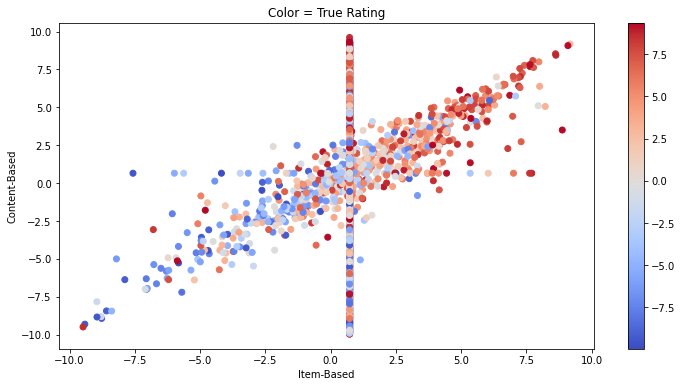

In [12]:
# visualize
scatter_df = lr_train.sample(10000, random_state=42)
plt.figure(figsize = (12, 6))
plt.scatter(x=scatter_df.ib_pred, y=scatter_df.cb_pred, c=scatter_df.target, cmap='coolwarm')
plt.xlabel('Item-Based')
plt.ylabel('Content-Based')
plt.title('Color = True Rating')
plt.colorbar()

In [13]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

# Exercise 3

In [14]:
# import second dataset
data2 = pd.read_csv('../Data/jester/jester_test.csv')

# surprise dataset format
df_test2 = list(data2.itertuples(index=False, name=None))

data2.head()

,user,item,rating
0,0,4,5.34
1,0,5,-5.05
2,0,6,4.37
3,0,7,3.98
4,0,8,-2.04


In [15]:
data2.shape

(904451, 3)

In [16]:
# make prediction

# Content Based
cb_pred2 = cb.test(df_test2)

# Item Based
ib_pred2 = ib.test(df_test2)

# convert to df
df_pred_cb2, df_pred_ib2 = pd.DataFrame(cb_pred2), pd.DataFrame(ib_pred2)

##### Hybrid - Mean
df_hybrid2 = df_pred_ib2.copy()
df_hybrid2['est'] = (np.array(df_pred_cb2['est']) + np.array(df_pred_ib2['est'])) / 2

In [17]:
##### Hybrid - Linear Regression model
# get test set
lr_test = df_pred_ib2[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_test['cb_pred'] = df_pred_cb2['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr = df_pred_ib2.copy()
df_lr['est'] = lr_pred

In [18]:
# Evaluate

models = {"CB_10":cb_pred2, "IB_15":ib_pred2, "Hybrid_CB_IB":df_hybrid2, "Hybrid_LR":df_lr}
overview2 = pd.concat([eval.prediction_metrics(pred) for pred in models.values()], axis=1)
overview2.columns = list(models.keys())
overview2

,CB_10,IB_15,Hybrid_CB_IB,Hybrid_LR
RMSE,6.508849,5.371713,5.667015,5.474752
MAE,5.288782,4.470180,4.684540,4.552514


# Additional Exercise

# RandomForest

In [19]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

,target,ib_pred,cb_pred
0,-1.55,0.728384,-2.570
1,-2.86,0.728384,-1.550
2,0.00,0.728384,-6.500
3,-9.42,0.728384,-9.420
4,-0.63,0.728384,-0.585


In [20]:
from sklearn.ensemble import RandomForestRegressor

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [21]:
# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_pred_ib2.copy()
df_rf['est'] = rf_pred

In [22]:
# Evaluate
rf_res = eval.prediction_metrics(df_rf).rename(columns={'value':'Hybrid_RF'})

In [23]:
# Display Overview
overview3 = pd.concat([overview2, rf_res], axis=1)
overview3

,CB_10,IB_15,Hybrid_CB_IB,Hybrid_LR,Hybrid_RF
RMSE,6.508849,5.371713,5.667015,5.474752,5.472945
MAE,5.288782,4.470180,4.684540,4.552514,4.550658
